In [44]:
%matplotlib inline
import matplotlib.pyplot as plt


# import os
# import sys
# sys.path.append(os.path.dirname(os.getcwd())) # top-level of code

from collections import defaultdict
import random
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm

from ortools.linear_solver import pywraplp

from covid_xprize.scoring.prescriptor_scoring import compute_pareto_set
from covid_xprize.scoring.prescriptor_scoring import compute_domination_df

from covid_xprize.standard_predictor.xprize_predictor import XPrizePredictor

In [2]:
NPI_COLS_NAMES = ['C1_School closing',
            'C2_Workplace closing',
            'C3_Cancel public events',
            'C4_Restrictions on gatherings',
            'C5_Close public transport',
            'C6_Stay at home requirements',
            'C7_Restrictions on internal movement',
            'C8_International travel controls',
            'H1_Public information campaigns',
            'H2_Testing policy',
            'H3_Contact tracing',
            'H6_Facial Coverings']

In [3]:
NPI_values = [[0,1,2,3],
             [0,1,2,3],
             [0,1,2],
             [0,1,2,3,4],
             [0,1,2],
             [0,1,2,3],
             [0,1,2],
             [0,1,2,3,4],
             [0,1,2],
             [0,1,2,3],
             [0,1,2],
             [0,1,2,3,4]]

In [7]:
NPI_dict = {}
for i, col in enumerate(NPI_COLS_NAMES):
    NPI_dict[col] = NPI_values[i]
NPI_dict

{'C1_School closing': [0, 1, 2, 3],
 'C2_Workplace closing': [0, 1, 2, 3],
 'C3_Cancel public events': [0, 1, 2],
 'C4_Restrictions on gatherings': [0, 1, 2, 3, 4],
 'C5_Close public transport': [0, 1, 2],
 'C6_Stay at home requirements': [0, 1, 2, 3],
 'C7_Restrictions on internal movement': [0, 1, 2],
 'C8_International travel controls': [0, 1, 2, 3, 4],
 'H1_Public information campaigns': [0, 1, 2],
 'H2_Testing policy': [0, 1, 2, 3],
 'H3_Contact tracing': [0, 1, 2],
 'H6_Facial Coverings': [0, 1, 2, 3, 4]}

In [8]:
col_names = ['PrescriptionIndex', 'CountryName', 'RegionName', 'Date'] + NPI_COLS_NAMES

In [9]:
START_DATE = np.datetime64("2020-08-01")
END_DATE = np.datetime64("2020-08-05")

In [10]:
# case_weights_2 = d.read_csv('weights_7_past.csv', index_col=0)
case_weights_dict = {}

with open("weights_reformat.pickle", "rb") as file:
    case_weights_dict['case_weights_1'] = pickle.load(file)
# case_weights_dict['case_weights_1'] = pd.read_csv('weights_reformat.pickle', index_col=0)
# case_weights_dict['case_weights_7'] = pd.read_csv('weights_7_reformat.csv', index_col=0) # need to process
# case_weights_dict['case_weights_7_past'] = pd.read_csv('case_weights_7_past_reformat.csv', index_col=0) # need to process

# case_weights_names = ['case_weights_1', 'case_weights_7', 'case_weights_7_past']
case_weights_names = ['case_weights_1']
num_case_weights = len(case_weights_names)

In [172]:
case_weights_dict['case_weights_1']

{'Afghanistan': {'C1_School closing': {0: 0,
   1: -0.01615561432639605,
   2: -0.0310491908752276,
   3: -0.04482530270726857},
  'C2_Workplace closing': {0: 0,
   1: -0.01862271108698264,
   2: -0.03621470129363711,
   3: -0.052878022192272785},
  'C3_Cancel public events': {0: 0,
   1: -0.0037912159113063777,
   2: -0.007291584841528199},
  'C4_Restrictions on gatherings': {0: 0,
   1: -0.006228547629969706,
   2: -0.011957042555621421,
   3: -0.01723055755472535,
   4: -0.022100118413435746},
  'C5_Close public transport': {0: 0,
   1: -0.00992196411781136,
   2: -0.018788544891985847},
  'C6_Stay at home requirements': {0: 0,
   1: -0.00511023248340934,
   2: -0.009658330889345262,
   3: -0.013720833897040638},
  'C7_Restrictions on internal movement': {0: 0,
   1: -0.005467412986493821,
   2: -0.010562337734055507},
  'C8_International travel controls': {0: 0,
   1: -0.007618149872919077,
   2: -0.014431793184131203,
   3: -0.02053192591894272,
   4: -0.026009544062667506},
  'H1

In [11]:
def default_to_regular(d):
    if isinstance(d, defaultdict):
        d = {k: default_to_regular(v) for k, v in d.items()}
    return d
# case_weights = default_to_regular(case_weights)

In [12]:
# with open('weights_reformat.pickle', 'wb') as file:
#     pickle.dump(case_weights_dict['case_weights_1'], file)

In [13]:
case_weights_dict['case_weights_1']['Afghanistan']['C1_School closing'][1]

-0.01615561432639605

In [14]:
# for geo in GeoIDs:
#     w_sum = 0
#     for col in NPI_COLS_NAMES:
#         for j in range(len(NPI_dict[col])):
#             w_sum -= case_weights_dict['case_weights_1'][geo][col][j]
# #             print(w_sum)
#     if w_sum >= 1:
#         print(geo, ': ', w_sum)
# #         for col in NPI_COLS_NAMES:
# #             for j in range(len(NPI_dict[col])):
# #                 case_weights_dict['case_weights_1'][geo][col][j] = case_weights_dict['case_weights_1'][geo][col][j]/w_sum


In [15]:
# for col in NPI_COLS_NAMES:
#     for j in range(len(NPI_dict[col])):
#         case_weights_dict['case_weights_1']['United States / Virgin Islands'][col][j] = 0

In [16]:
case_weights_dict['case_weights_1']['United States / Virgin Islands']

{'C1_School closing': {0: 0, 1: 0, 2: 0, 3: 0},
 'C2_Workplace closing': {0: 0, 1: 0, 2: 0, 3: 0},
 'C3_Cancel public events': {0: 0, 1: 0, 2: 0},
 'C4_Restrictions on gatherings': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0},
 'C5_Close public transport': {0: 0, 1: 0, 2: 0},
 'C6_Stay at home requirements': {0: 0, 1: 0, 2: 0, 3: 0},
 'C7_Restrictions on internal movement': {0: 0, 1: 0, 2: 0},
 'C8_International travel controls': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0},
 'H1_Public information campaigns': {0: 0, 1: 0, 2: 0},
 'H2_Testing policy': {0: 0, 1: 0, 2: 0, 3: 0},
 'H3_Contact tracing': {0: 0, 1: 0, 2: 0},
 'H6_Facial Coverings': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}}

In [17]:
# import math

# for geo in case_weights_dict['case_weights_1'].keys():
# #     print(geo)
#     for col in NPI_COLS_NAMES:
#         for j in range(len(NPI_dict[col])):
# #             print(geo, ' ', col, ' ', j)
#             case_weights_dict['case_weights_1'][geo][col][j] = math.floor(case_weights_dict['case_weights_1'][geo][col][j] *10000)/10000.0
# # math.floor(a * 100)/100.0

In [18]:
# case_weights = defaultdict(lambda : defaultdict(lambda : defaultdict(int)))
# for geo in GeoIDs:
#     for col in NPI_COLS_NAMES:
#         case_weights[geo][col][0] = 0

In [19]:
# for index, row in case_weights_dict['case_weights_1'].iterrows():
#     case_weights[row['Country_Region']][row['IP']][row['IP Val']] = row['impact']/100

In [20]:
# stringency weights

stringency_weight_df = pd.read_csv("covid_xprize/validation/data/uniform_random_costs.csv")
stringency_weight_df["GeoID"] = np.where(stringency_weight_df["RegionName"].isnull(),
                                      stringency_weight_df["CountryName"],
                                      stringency_weight_df["CountryName"] + ' / ' + stringency_weight_df["RegionName"])

In [57]:
GeoIDs = stringency_weight_df["GeoID"].values
countries = stringency_weight_df["CountryName"].values
regions = stringency_weight_df["RegionName"].values

In [29]:
stringency_weight = defaultdict(lambda : defaultdict(lambda : defaultdict(np.float64)))

In [30]:
for index, row in stringency_weight_df.iterrows():
    row_sum = 0
    for col in NPI_COLS_NAMES:
        row_sum +=  row[col]*sum(NPI_dict[col])
#     row_sum = row[NPI_COLS_NAMES].sum()
    for col in NPI_COLS_NAMES:
        for j in range(len(NPI_dict[col])):
#             tmp.append((stringency_weight_tmp[i] * (NPI_values[i][j]))/stringency_weight_sum)
            stringency_weight[row['GeoID']][col][j] = (row[col] * NPI_dict[col][j])/row_sum

In [31]:
stringency_weight = default_to_regular(stringency_weight)

In [32]:
stringency_weight['Canada']['C1_School closing'][1]

0.012623490669593854

In [33]:
# set global variables
# num_IP = 12 
data_url = 'covid_xprize/standard_predictor/data/OxCGRT_latest.csv'
OxCGRT_latest = pd.read_csv(data_url,
                                parse_dates=['Date'],
                                encoding="ISO-8859-1",
                                dtype={"RegionName": str,
                                       "RegionCode": str},
                                error_bad_lines=False)
OxCGRT_latest["GeoID"] = np.where(OxCGRT_latest["RegionName"].isnull(),
                                      OxCGRT_latest["CountryName"],
                                      OxCGRT_latest["CountryName"] + ' / ' + OxCGRT_latest["RegionName"])
OxCGRT_latest['NewCases'] = OxCGRT_latest.groupby('GeoID').ConfirmedCases.diff().fillna(0)
initial_day_cases = OxCGRT_latest[OxCGRT_latest['Date'] == '2020-07-31'].set_index('GeoID')[['NewCases']]
initial_day_cases['NewCases'] = initial_day_cases['NewCases'].replace(0, 1)
initial_day_cases.loc['Canada']

NewCases    604.0
Name: Canada, dtype: float64

In [131]:
def run_opt(previous_day_cases, case_weight, stringency_weight, geo_id):
    solver = pywraplp.Solver.CreateSolver('SCIP')
    
    # Create variables
    x = {}
    for i,col in enumerate(NPI_COLS_NAMES):
        for j in range(len(NPI_dict[col])):
            x[i, j] = solver.IntVar(0, 1, (geo_id + '_' + col + '_' + str(NPI_values[i][j])))
    
    # Create contraint

    for i,col in enumerate(NPI_COLS_NAMES):
        solver.Add(solver.Sum([x[i, j] for j in range(len(NPI_dict[col]))]) == 1)
    
    # Create objective function

    objective_terms = []
    objective_terms.append((previous_day_cases.loc[geo_id]['NewCases']/initial_day_cases.loc[geo_id]['NewCases'])) # scale to initial number of cases
    
    for i,col in enumerate(NPI_COLS_NAMES):
        for j in range(len(NPI_dict[col])):
#             print(previous_day_case.loc[geo_id]['NewCases'])
            objective_terms.append(((case_weight[col][j] * x[i,j]) * previous_day_cases.loc[geo_id]['NewCases'])/initial_day_cases.loc[geo_id]['NewCases'])
    for i,col in enumerate(NPI_COLS_NAMES):
        for j in range(len(NPI_dict[col])):
#             print(stringency_weight[col][j])
            objective_terms.append(stringency_weight[col][j] * x[i, j])
    solver.Minimize(solver.Sum(objective_terms))
    
    status = solver.Solve()
#     print(status)
    
    solution = []
    for i,col in enumerate(NPI_COLS_NAMES): 
        for j in range(len(NPI_dict[col])):
            if x[i,j].solution_value() > 0.5:
#                 print(x[i,j], ': ', x[i,j].solution_value())
                solution.append(j)
#     print('Total cost = ', solver.Objective().Value())
    return solution

In [42]:
previous_day_cases = initial_day_cases
geo = 'Canada'

run_opt(previous_day_cases, case_weights_dict['case_weights_1'][geo], stringency_weight[geo], geo)

0
Total cost =  0.9104576769083117 



[3, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0]

In [75]:
predictor = XPrizePredictor()

In [53]:
ip_file_path = 'test_prescriptions/'
preds_file_path = 'test_predictions/'
w = 'case_weights_1'

In [56]:
geo.split(' / ')

['Afghanistan']

In [63]:
prescriptions_total_df = pd.DataFrame(columns = col_names)
predictions_total = []

ip_solution_all = []
for geo, country, RegionName in tqdm(zip(GeoIDs, countries, regions)):
    cur_case_weight = case_weights_dict[w][geo]
    cur_stringency_weight = stringency_weight[geo]

    cur_start_date = START_DATE + np.timedelta64(i,'D')
    cur_end_date = START_DATE + np.timedelta64(i,'D')
    cur_ip_file_path = ip_file_path + 'prescriptions_initial_' + w + '_'+ str(cur_start_date) + '.csv'

    ip_solution = run_opt(previous_day_cases, cur_case_weight, cur_stringency_weight, geo)
    predictions_total.append([0] + [country] + [RegionName] + [str(cur_start_date)] + ip_solution)


# prescriptions_df = pd.DataFrame(columns=col_names)
# prescriptions_df.loc[0] = prescriptions
# prescriptions_total_df.loc[i] = prescriptions

# prescriptions_df.to_csv(cur_ip_file_path)

10it [00:00, 45.55it/s]

Total cost =  0.9791413067642054
Total cost =  0.9310595913420372
Total cost =  0.9385589197137688
Total cost =  0.9549973382121619
Total cost =  0.9676738764639063
Total cost =  0.9794943420865799
Total cost =  0.9292907693065761
Total cost =  0.9463473926012069
Total cost =  0.8838144613435164
Total cost =  0.9845864423134751
Total cost =  0.7649741926089695
Total cost =  0.989223073933231


22it [00:00, 48.61it/s]

Total cost =  0.9933512904569002
Total cost =  0.9823077256424327
Total cost =  0.9796292846167659
Total cost =  0.8913437284471276
Total cost =  0.8313048193996363
Total cost =  0.9132279258984414
Total cost =  0.9980369798723044
Total cost =  0.9994848879943746
Total cost =  0.9640883048958331
Total cost =  0.9951108245774856
Total cost =  0.9164130474996806
Total cost =  0.9259840717662604


34it [00:00, 50.58it/s]

Total cost =  0.8293197702583726
Total cost =  0.9034770485181259
Total cost =  0.9702863480609883
Total cost =  0.9109430574756159
Total cost =  0.9893879692259291
Total cost =  0.7950112582769431
Total cost =  0.9104576769083117
Total cost =  0.8528920325882768
Total cost =  0.857639384416582
Total cost =  0.9705808874296108
Total cost =  0.9897762476805463
Total cost =  0.9522788709333635
Total cost =  0.9876090668639441


45it [00:00, 47.04it/s]

Total cost =  0.9812406103755583
Total cost =  1.0
Total cost =  0.8387058527207066
Total cost =  0.8858584407935485
Total cost =  0.7972768588859659
Total cost =  0.9470207276215631
Total cost =  0.8366390968738383
Total cost =  0.8839415654629001
Total cost =  0.9768567609663121
Total cost =  0.9336150779081452
Total cost =  0.8902233058492112
Total cost = 

55it [00:01, 47.81it/s]

 1.0
Total cost =  0.9892449194085963
Total cost =  0.931995556802983
Total cost =  0.9934959923697864
Total cost =  0.8142090611970505
Total cost =  0.9458088241696745
Total cost =  0.9767553527337908
Total cost =  0.9895316683233433
Total cost =  0.9935845097429807
Total cost =  0.9848235219777941
Total cost =  0.8562336850411083


65it [00:01, 45.15it/s]

Total cost =  0.9390860908800147
Total cost =  0.7972860584082675
Total cost =  0.7681823120406924
Total cost =  0.8982591904299196
Total cost =  0.9678832194444384
Total cost =  0.9575519267392757
Total cost =  0.9928362861285848
Total cost =  0.8433001697280764
Total cost =  0.8766583932030806
Total cost = 

75it [00:01, 45.20it/s]

 0.825019506780681
Total cost =  0.8663483373501949
Total cost =  0.8329497193694909
Total cost =  0.8003842180543805
Total cost =  0.8511369563806558
Total cost =  0.9893828962946961
Total cost =  0.9998903782619613
Total cost =  0.9324055968864355
Total cost =  0.8548239999268314
Total cost =  0.9660943718617343
Total cost =  0.9764037605610385


86it [00:01, 48.26it/s]

Total cost =  0.9856284276699526
Total cost =  0.9822610889207439
Total cost =  0.9718204149872459
Total cost =  0.9603110144495086
Total cost =  0.9506157930364562
Total cost =  0.9852383818067801
Total cost =  0.9971222816322212
Total cost =  0.9582892175464828
Total cost =  1.0
Total cost =  0.9685343144157555
Total cost =  0.999435778670196
Total cost =  0.9480400076501394


98it [00:02, 49.20it/s]

Total cost =  0.9927661715075204
Total cost =  1.0
Total cost =  0.9239574679239516
Total cost =  0.9751733077722912
Total cost =  0.9170029107308164
Total cost =  1.0
Total cost =  0.8203386050500743
Total cost =  0.9604703453147414
Total cost =  1.0
Total cost =  1.0
Total cost =  0.8192687973081504


110it [00:02, 50.64it/s]

Total cost =  0.9553599365920098
Total cost =  0.9927829368351212
Total cost =  0.9953612943175888
Total cost =  0.9728939485427617
Total cost =  1.0
Total cost =  0.9330052377152835
Total cost =  0.9469758347512396
Total cost =  0.9679193720212124
Total cost =  1.0
Total cost =  0.9831816396120804
Total cost =  0.9481806768506261
Total cost =  0.949570362462709


122it [00:02, 51.78it/s]

Total cost =  0.9503051069120005
Total cost =  0.9556225780029011
Total cost =  0.967788955496099
Total cost =  0.9897606275575478
Total cost =  0.8370910265089017
Total cost =  0.982109600036891
Total cost =  0.9492548171641965
Total cost =  0.9601818752238891
Total cost =  0.885824716627179
Total cost =  0.9665321507899889
Total cost =  0.9844125745129868


134it [00:02, 49.19it/s]

Total cost =  0.982632574319792
Total cost =  1.0
Total cost =  0.9156776438038888
Total cost =  0.9797778018374764
Total cost =  0.9767134986728376
Total cost =  0.9083038737760872
Total cost =  0.8583988767496742
Total cost =  0.9941584221692961
Total cost =  0.9594850923968118
Total cost =  0.83647922557371
Total cost =  0.995620776039985
Total cost = 

145it [00:02, 49.65it/s]

 0.9899004882385106
Total cost =  0.7921681090952808
Total cost =  0.9752914046395748
Total cost =  0.994699392440384
Total cost =  0.987655977329251
Total cost =  0.992012872203389
Total cost =  0.9170057101120754
Total cost =  0.9499665837462677
Total cost =  0.9424609464014578
Total cost =  0.9014689329763981
Total cost =  1.0
Total cost =  0.8509504038645749
Total cost =  0.9985429043500026


156it [00:03, 49.00it/s]

Total cost =  0.9816183361186921
Total cost =  0.9719009613162545
Total cost =  0.8030827150293378
Total cost =  0.9672388171576983
Total cost =  1.0
Total cost =  0.976855561052444
Total cost =  0.7932617081643987
Total cost =  0.825381794646495
Total cost =  0.9815648653514688
Total cost =  0.9821376016965041
Total cost =  1.0


168it [00:03, 49.47it/s]

Total cost =  1.0
Total cost =  0.9649623283737638
Total cost =  0.9424693273976368
Total cost =  0.9523491896682631
Total cost =  0.9855513103949802
Total cost =  0.9961928336193797
Total cost =  0.9436612451216825
Total cost =  0.9892132274598078
Total cost =  0.9936861606547529
Total cost =  0.9610976501070768
Total cost =  0.990200058081881
Total cost =  0.9953860139649036


179it [00:03, 49.08it/s]

Total cost =  0.9907309350944561
Total cost =  0.9816187329902459
Total cost =  0.9292384242557855
Total cost =  0.9918789820840127
Total cost =  0.8245834234907163
Total cost =  1.0
Total cost =  0.9843853679347194
Total cost =  0.8997875874923418
Total cost =  0.9763534320399025
Total cost =  0.9576614753129197
Total cost =  0.8373601677864161
Total cost =  0.9775603795666956


191it [00:03, 51.19it/s]

Total cost =  1.0
Total cost =  0.9765475521437994
Total cost =  0.974169857435507
Total cost =  0.8328543864912563
Total cost =  0.8536904774184684
Total cost =  0.9919664947702083
Total cost =  0.8520712404580322
Total cost =  0.8925599695503045
Total cost =  0.9992199571666731
Total cost =  0.8465522143899776
Total cost =  0.8385602218125212


203it [00:04, 50.82it/s]

Total cost =  0.9830760452489833
Total cost =  0.9996026820878244
Total cost =  0.9946310003887304
Total cost =  0.9742695651757739
Total cost =  0.9139230303943938
Total cost =  0.9906729933247898
Total cost =  0.9602055733763669
Total cost =  0.8652209271944148
Total cost =  0.9355888318978114
Total cost =  0.9992169677936532
Total cost =  0.9558846398930979
Total cost =  0.8779894655239388
Total cost = 

215it [00:04, 50.47it/s]

 0.9816962693516046
Total cost =  0.9953689820151638
Total cost =  0.8603695445413805
Total cost =  0.9737718278438238
Total cost =  1.0
Total cost =  0.9899785063008418
Total cost =  0.9724888643003874
Total cost =  0.8228971199964381
Total cost =  0.9919662474523396
Total cost =  0.9356600050879736
Total cost =  0.9804904882541515
Total cost =  0.8502387159973076


227it [00:04, 50.94it/s]

Total cost =  0.9903615053324226
Total cost =  0.9909350905462517
Total cost =  1.0
Total cost =  0.9013565474998089
Total cost =  0.9938046601758092
Total cost =  0.9892941071783011
Total cost =  0.9853894588262299
Total cost =  0.8730542471944578
Total cost =  0.9821473640334617
Total cost =  0.9408096393203298
Total cost =  1.0
Total cost = 

236it [00:04, 49.66it/s]

 1.0
Total cost =  0.9489572459062819
Total cost =  0.955083112422246
Total cost =  0.9594588621619077
Total cost =  0.9674142401334358
Total cost =  0.9388862226698067


In [64]:
predictions_total

[[0, 'Afghanistan', nan, '2020-08-12', 3, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 'Albania', nan, '2020-08-12', 3, 0, 2, 0, 2, 0, 0, 4, 0, 0, 0, 0],
 [0, 'Algeria', nan, '2020-08-12', 3, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0],
 [0, 'Andorra', nan, '2020-08-12', 3, 0, 0, 4, 2, 0, 0, 0, 2, 0, 0, 0],
 [0, 'Angola', nan, '2020-08-12', 1, 3, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0],
 [0, 'Argentina', nan, '2020-08-12', 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 'Aruba', nan, '2020-08-12', 3, 3, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0],
 [0, 'Australia', nan, '2020-08-12', 0, 3, 0, 0, 0, 0, 0, 4, 2, 0, 2, 0],
 [0, 'Austria', nan, '2020-08-12', 3, 3, 0, 0, 2, 0, 0, 4, 0, 3, 0, 0],
 [0, 'Azerbaijan', nan, '2020-08-12', 1, 0, 0, 4, 0, 0, 0, 0, 0, 0, 2, 0],
 [0, 'Bahamas', nan, '2020-08-12', 3, 3, 0, 0, 2, 0, 0, 4, 2, 0, 0, 0],
 [0, 'Bahrain', nan, '2020-08-12', 0, 0, 0, 0, 0, 0, 2, 4, 0, 0, 0, 0],
 [0, 'Bangladesh', nan, '2020-08-12', 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 'Barbados', nan, '2020-08-12', 0, 3, 0, 2, 2, 0,

In [70]:
prescriptions_df = pd.DataFrame()
prescriptions_df = prescriptions_df.append(pd.DataFrame(predictions_total))
prescriptions_df.columns = col_names

In [74]:
prescriptions_df.to_csv(cur_ip_file_path)


In [93]:
previous_day_cases = predictor.predict(cur_start_date, cur_start_date, cur_ip_file_path)
previous_day_cases["GeoID"] = np.where(previous_day_cases["RegionName"].isnull(),
                                      previous_day_cases["CountryName"],
                                      previous_day_cases["CountryName"] + ' / ' + previous_day_cases["RegionName"])
previous_day_cases = previous_day_cases.set_index('GeoID')[['PredictedDailyNewCases']]

In [100]:
predictions_total = pd.DataFrame()
predictions_total['08'] = previous_day_cases['PredictedDailyNewCases']
predictions_total

,08
GeoID,
Afghanistan,69.844625
Albania,191.429374
Algeria,689.397785
Andorra,1.247970
Angola,76.109381
...,...
Venezuela,1311.499490
Vietnam,64.061432
Yemen,7.331228


In [99]:
previous_day_cases

,PredictedDailyNewCases
GeoID,
Afghanistan,69.844625
Albania,191.429374
Algeria,689.397785
Andorra,1.247970
Angola,76.109381
...,...
Venezuela,1311.499490
Vietnam,64.061432
Yemen,7.331228


In [105]:
prescriptions_total_df = pd.DataFrame(columns = col_names)
prescriptions_total_df = prescriptions_total_df.append(prescriptions_df)

In [139]:
predictions_total

[[0, 'Afghanistan', nan, '2020-08-01', 3, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 'Albania', nan, '2020-08-01', 3, 0, 2, 0, 2, 0, 0, 4, 0, 0, 0, 0],
 [0, 'Algeria', nan, '2020-08-01', 3, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0],
 [0, 'Andorra', nan, '2020-08-01', 3, 0, 0, 4, 2, 0, 0, 0, 2, 0, 0, 0],
 [0, 'Angola', nan, '2020-08-01', 1, 3, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0],
 [0, 'Argentina', nan, '2020-08-01', 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 'Aruba', nan, '2020-08-01', 3, 3, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0],
 [0, 'Australia', nan, '2020-08-01', 0, 3, 0, 0, 0, 0, 0, 4, 2, 0, 2, 0],
 [0, 'Austria', nan, '2020-08-01', 3, 3, 0, 0, 2, 0, 0, 4, 0, 3, 0, 0],
 [0, 'Azerbaijan', nan, '2020-08-01', 1, 0, 0, 4, 0, 0, 0, 0, 0, 0, 2, 0],
 [0, 'Bahamas', nan, '2020-08-01', 3, 3, 0, 0, 2, 0, 0, 4, 2, 0, 0, 0],
 [0, 'Bahrain', nan, '2020-08-01', 0, 0, 0, 0, 0, 0, 2, 4, 0, 0, 0, 0],
 [0, 'Bangladesh', nan, '2020-08-01', 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 'Barbados', nan, '2020-08-01', 0, 3, 0, 2, 2, 0,

In [141]:
previous_day_cases

,PredictedDailyNewCases
GeoID,
Afghanistan,71.932956
Albania,101.918837
Algeria,803.926757
Andorra,3.689214
Angola,52.985407
...,...
Venezuela,957.254910
Vietnam,29.984059
Yemen,0.448796


In [169]:
cur_start_date

numpy.datetime64('2020-08-05')

In [170]:
pd.read_csv(cur_ip_file_path)

,Unnamed: 0,PrescriptionIndex,CountryName,RegionName,Date,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C5_Close public transport,C6_Stay at home requirements,C7_Restrictions on internal movement,C8_International travel controls,H1_Public information campaigns,H2_Testing policy,H3_Contact tracing,H6_Facial Coverings
0,0,0,Afghanistan,NaN,2020-08-05,2,0,0,4,0,0,0,0,0,0,0,0
1,1,0,Albania,NaN,2020-08-05,3,3,2,0,2,0,0,4,0,0,2,0
2,2,0,Algeria,NaN,2020-08-05,3,3,0,0,0,0,0,0,0,3,0,0
3,3,0,Andorra,NaN,2020-08-05,3,0,0,4,2,0,0,0,2,0,0,0
4,4,0,Angola,NaN,2020-08-05,3,3,0,4,2,1,0,0,2,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,231,0,Venezuela,NaN,2020-08-05,3,1,0,0,2,0,0,4,0,0,0,0
232,232,0,Vietnam,NaN,2020-08-05,3,3,0,0,1,0,2,0,0,0,2,0
233,233,0,Yemen,NaN,2020-08-05,3,3,2,4,2,3,2,4,2,3,2,4
234,234,0,Zambia,NaN,2020-08-05,0,0,2,0,0,3,0,4,2,0,2,0


In [168]:
predictor.predict(cur_start_date, cur_start_date, cur_ip_file_path)

,CountryName,RegionName,Date,PredictedDailyNewCases
0,Afghanistan,NaN,2020-08-05,114.089545
1,Albania,NaN,2020-08-05,141.742956
2,Algeria,NaN,2020-08-05,770.052086
3,Andorra,NaN,2020-08-05,13.515185
4,Angola,NaN,2020-08-05,99.272723
...,...,...,...,...
231,Venezuela,NaN,2020-08-05,907.841782
232,Vietnam,NaN,2020-08-05,50.573803
233,Yemen,NaN,2020-08-05,9.124966
234,Zambia,NaN,2020-08-05,376.895588


In [165]:
%%time

ip_file_path = 'test_prescriptions/'
preds_file_path = 'test_predictions/'

# Run predictor
# !python covid_xprize/standard_predictor/predict.py -s $START_DATE -e $END_DATE -ip $ip_file_path -o $preds_file_path
import datetime

day_count = (END_DATE - START_DATE)/np.timedelta64(1, 'D')

previous_day_cases = initial_day_cases
for w in case_weights_names:
    
    prescriptions_total_df = pd.DataFrame(columns = col_names)
    predictions_total = pd.DataFrame()
    
    for i in tqdm(range(int(day_count) + 1)):
        cur_start_date = START_DATE + np.timedelta64(i,'D')
        cur_end_date = START_DATE + np.timedelta64(i,'D')
        cur_ip_file_path = ip_file_path + 'prescriptions_initial_' + w + '_'+ str(cur_start_date) + '.csv'
        print('prescribing for day ' + str(cur_start_date))

        prescriptions_total = []
            
        ip_solution_all = []
        for geo, country, RegionName in tqdm(zip(GeoIDs, countries, regions)):
            cur_case_weight = case_weights_dict[w][geo]
            cur_stringency_weight = stringency_weight[geo]

            ip_solution = run_opt(previous_day_cases, cur_case_weight, cur_stringency_weight, geo)
            prescriptions_total.append([0] + [country] + [RegionName] + [str(cur_start_date)] + ip_solution)
            
            
        prescriptions_df = pd.DataFrame()
        prescriptions_df = prescriptions_df.append(pd.DataFrame(prescriptions_total))
        prescriptions_df.columns = col_names
        
        prescriptions_total_df = prescriptions_total_df.append(prescriptions_df)

        prescriptions_df.to_csv(cur_ip_file_path)

        # predict for next day for all geo
        print('predicting for day ' + str(cur_start_date))
        previous_day_cases = predictor.predict(cur_start_date, cur_start_date, cur_ip_file_path)
        previous_day_cases["GeoID"] = np.where(previous_day_cases["RegionName"].isnull(),
                                              previous_day_cases["CountryName"],
                                              previous_day_cases["CountryName"] + ' / ' + previous_day_cases["RegionName"])
        previous_day_cases = previous_day_cases.set_index('GeoID')[['PredictedDailyNewCases']]
        previous_day_cases.rename(columns={'PredictedDailyNewCases':'NewCases'}, inplace=True)
        
        predictions_total[cur_start_date] = previous_day_cases['NewCases']
        
    
    final_ip_path = ip_file_path + 'final_prescriptions_' + w + '_'+ str(cur_start_date) + '.csv'
    prescriptions_total_df.to_csv(final_ip_path)
    final_pred_path = preds_file_path + 'final_predictions_' + w + '_'+ str(cur_start_date) + '.csv'
    predictions_total.to_csv(final_pred_path)


  0%|          | 0/5 [00:00<?, ?it/s]
0it [00:00, ?it/s]
4it [00:00, 36.78it/s]

prescribing for day 2020-08-01



9it [00:00, 38.58it/s]
14it [00:00, 40.46it/s]
19it [00:00, 42.75it/s]
23it [00:00, 39.89it/s]
29it [00:00, 42.64it/s]
34it [00:00, 42.77it/s]
39it [00:00, 42.76it/s]
44it [00:01, 41.85it/s]
49it [00:01, 40.83it/s]
54it [00:01, 41.60it/s]
59it [00:01, 42.78it/s]
64it [00:01, 42.41it/s]
69it [00:01, 43.23it/s]
74it [00:01, 44.34it/s]
79it [00:01, 44.12it/s]
85it [00:01, 46.05it/s]
91it [00:02, 47.86it/s]
96it [00:02, 48.37it/s]
101it [00:02, 48.75it/s]
106it [00:02, 48.46it/s]
112it [00:02, 49.82it/s]
118it [00:02, 50.08it/s]
124it [00:02, 50.73it/s]
130it [00:02, 49.16it/s]
135it [00:02, 48.26it/s]
140it [00:03, 44.27it/s]
145it [00:03, 44.62it/s]
150it [00:03, 44.86it/s]
155it [00:03, 45.66it/s]
160it [00:03, 45.95it/s]
165it [00:03, 45.61it/s]
170it [00:03, 42.13it/s]
176it [00:03, 45.01it/s]
182it [00:04, 46.68it/s]
188it [00:04, 48.17it/s]
194it [00:04, 49.11it/s]
200it [00:04, 50.16it/s]
206it [00:04, 50.62it/s]
212it [00:04, 51.14it/s]
218it [00:04, 51.62it/s]
224it [00:04, 50.8

predicting for day 2020-08-01


 20%|██        | 1/5 [00:08<00:33,  8.36s/it]
0it [00:00, ?it/s]
6it [00:00, 51.93it/s]

prescribing for day 2020-08-02



11it [00:00, 50.41it/s]
16it [00:00, 48.64it/s]
21it [00:00, 48.06it/s]
27it [00:00, 48.80it/s]
32it [00:00, 48.88it/s]
38it [00:00, 49.91it/s]
44it [00:00, 50.25it/s]
50it [00:01, 50.73it/s]
55it [00:01, 49.76it/s]
61it [00:01, 50.07it/s]
66it [00:01, 49.93it/s]
71it [00:01, 49.36it/s]
76it [00:01, 49.27it/s]
82it [00:01, 50.18it/s]
88it [00:01, 50.61it/s]
94it [00:01, 50.26it/s]
100it [00:02, 50.99it/s]
106it [00:02, 50.86it/s]
112it [00:02, 51.07it/s]
118it [00:02, 51.68it/s]
124it [00:02, 50.54it/s]
130it [00:02, 50.43it/s]
136it [00:02, 50.96it/s]
142it [00:02, 49.62it/s]
148it [00:02, 50.83it/s]
154it [00:03, 50.89it/s]
160it [00:03, 50.27it/s]
166it [00:03, 48.70it/s]
171it [00:03, 48.95it/s]
176it [00:03, 48.12it/s]
181it [00:03, 48.17it/s]
186it [00:03, 48.19it/s]
191it [00:03, 48.71it/s]
196it [00:03, 44.90it/s]
202it [00:04, 46.41it/s]
208it [00:04, 47.78it/s]
214it [00:04, 49.02it/s]
219it [00:04, 49.10it/s]
225it [00:04, 49.87it/s]
236it [00:04, 49.74it/s]


predicting for day 2020-08-02


 40%|████      | 2/5 [00:16<00:24,  8.24s/it]
0it [00:00, ?it/s]
6it [00:00, 49.37it/s]

prescribing for day 2020-08-03



11it [00:00, 47.49it/s]
17it [00:00, 48.67it/s]
22it [00:00, 48.89it/s]
28it [00:00, 49.90it/s]
34it [00:00, 50.28it/s]
40it [00:00, 51.00it/s]
46it [00:00, 51.13it/s]
52it [00:01, 51.31it/s]
58it [00:01, 51.46it/s]
64it [00:01, 51.75it/s]
70it [00:01, 51.49it/s]
76it [00:01, 47.60it/s]
81it [00:01, 44.95it/s]
86it [00:01, 40.86it/s]
91it [00:01, 40.95it/s]
96it [00:02, 40.20it/s]
101it [00:02, 41.87it/s]
106it [00:02, 42.98it/s]
111it [00:02, 43.61it/s]
116it [00:02, 44.33it/s]
122it [00:02, 46.65it/s]
128it [00:02, 48.62it/s]
134it [00:02, 49.94it/s]
140it [00:02, 50.68it/s]
146it [00:03, 51.10it/s]
152it [00:03, 51.45it/s]
158it [00:03, 51.19it/s]
164it [00:03, 48.16it/s]
169it [00:03, 46.33it/s]
175it [00:03, 48.02it/s]
180it [00:03, 48.53it/s]
185it [00:03, 48.93it/s]
191it [00:03, 49.84it/s]
197it [00:04, 49.76it/s]
202it [00:04, 48.08it/s]
208it [00:04, 49.40it/s]
214it [00:04, 49.62it/s]
219it [00:04, 49.67it/s]
225it [00:04, 50.55it/s]
236it [00:04, 48.34it/s]


predicting for day 2020-08-03


 60%|██████    | 3/5 [00:24<00:16,  8.23s/it]
0it [00:00, ?it/s]
6it [00:00, 45.84it/s]

prescribing for day 2020-08-04



9it [00:00, 37.36it/s]
12it [00:00, 34.31it/s]
17it [00:00, 37.85it/s]
23it [00:00, 40.91it/s]
28it [00:00, 43.09it/s]
34it [00:00, 45.23it/s]
39it [00:00, 45.83it/s]
44it [00:00, 46.36it/s]
49it [00:01, 47.25it/s]
55it [00:01, 48.43it/s]
61it [00:01, 49.57it/s]
67it [00:01, 50.43it/s]
73it [00:01, 50.74it/s]
79it [00:01, 51.01it/s]
85it [00:01, 52.51it/s]
91it [00:01, 53.53it/s]
97it [00:02, 53.44it/s]
103it [00:02, 52.87it/s]
109it [00:02, 53.69it/s]
115it [00:02, 52.94it/s]
121it [00:02, 53.64it/s]
127it [00:02, 53.81it/s]
133it [00:02, 53.18it/s]
139it [00:02, 52.54it/s]
145it [00:02, 51.98it/s]
151it [00:03, 50.59it/s]
157it [00:03, 48.68it/s]
162it [00:03, 45.26it/s]
167it [00:03, 44.95it/s]
172it [00:03, 46.24it/s]
178it [00:03, 47.64it/s]
183it [00:03, 47.02it/s]
188it [00:03, 45.50it/s]
193it [00:03, 44.11it/s]
198it [00:04, 44.72it/s]
204it [00:04, 46.84it/s]
209it [00:04, 45.46it/s]
214it [00:04, 44.20it/s]
219it [00:04, 43.69it/s]
224it [00:04, 44.84it/s]
229it [00:04, 44.

predicting for day 2020-08-04


 80%|████████  | 4/5 [00:33<00:08,  8.33s/it]
0it [00:00, ?it/s]
6it [00:00, 53.77it/s]

prescribing for day 2020-08-05



12it [00:00, 53.54it/s]
18it [00:00, 53.68it/s]
24it [00:00, 53.53it/s]
30it [00:00, 53.19it/s]
36it [00:00, 53.04it/s]
42it [00:00, 53.18it/s]
48it [00:00, 53.17it/s]
54it [00:01, 53.14it/s]
60it [00:01, 53.25it/s]
66it [00:01, 53.78it/s]
72it [00:01, 54.25it/s]
78it [00:01, 51.62it/s]
84it [00:01, 49.69it/s]
89it [00:01, 48.85it/s]
94it [00:01, 49.09it/s]
99it [00:01, 48.51it/s]
104it [00:02, 42.65it/s]
109it [00:02, 42.01it/s]
115it [00:02, 44.79it/s]
120it [00:02, 43.77it/s]
125it [00:02, 44.99it/s]
130it [00:02, 45.32it/s]
135it [00:02, 45.13it/s]
141it [00:02, 46.57it/s]
147it [00:02, 47.81it/s]
152it [00:03, 42.65it/s]
157it [00:03, 40.74it/s]
163it [00:03, 43.66it/s]
168it [00:03, 44.74it/s]
174it [00:03, 47.58it/s]
180it [00:03, 49.23it/s]
186it [00:03, 50.39it/s]
192it [00:03, 51.42it/s]
198it [00:04, 50.90it/s]
204it [00:04, 49.73it/s]
210it [00:04, 49.95it/s]
216it [00:04, 50.86it/s]
222it [00:04, 52.10it/s]
228it [00:04, 53.09it/s]
236it [00:04, 49.40it/s]


predicting for day 2020-08-05


100%|██████████| 5/5 [00:41<00:00,  8.24s/it]

CPU times: user 40.9 s, sys: 1.55 s, total: 42.4 s
Wall time: 41.2 s


In [144]:
IP_FILE = 'prescriptions/robojudge_test_scenario.csv'

In [166]:
pd.read_csv(final_pred_path, index_col = 0)

,2020-08-01,2020-08-02,2020-08-03,2020-08-04,2020-08-05
GeoID,,,,,
Afghanistan,71.932956,148.943497,121.340797,117.323356,114.089545
Albania,101.918837,162.968879,151.444457,149.511049,141.742956
Algeria,803.926757,784.343085,797.282323,810.287535,770.052086
Andorra,3.689214,3.344452,12.963158,2.561273,13.515185
Angola,52.985407,29.038488,34.211734,73.800989,99.272723
...,...,...,...,...,...
Venezuela,957.254910,828.062708,856.704826,909.138734,907.841782
Vietnam,29.984059,38.401173,49.501487,54.334222,50.573803
Yemen,0.448796,8.308887,10.258884,11.923323,9.124966


In [154]:
prescriptor_name = 'CCR'

In [167]:
from covid_xprize.validation.prescriptor_validation import validate_submission

errors = validate_submission(START_DATE, END_DATE, IP_FILE, final_ip_path)
if errors:
    for error in errors:
        print(f"{prescriptor_name}: {error}")
else:
    print(f"{prescriptor_name}: All good!")

CCR: All good!


In [128]:
    
    
#     prescriptions_total_df[NPI_COLS_NAMES] = prescriptions_total_df[NPI_COLS_NAMES].astype(int)

#     avg_pres = prescriptions_total_df.groupby(['CountryName', 
#                                        'RegionName', 
#                                        'PrescriptionIndex'], dropna=False).mean().reset_index().loc[0][NPI_COLS_NAMES].values
#     tot_stringency_cost = (stringency_weight_tmp * avg_pres).sum()
#     print(tot_stringency_cost)

#     avg_new_cases = np.mean(predictions_total)
#     print(avg_new_cases, '\n', '\n', '\n')

#     pres_name = 'CCR_opt_norm_initial_' + w
#     final_results.loc[len(final_results)] = [country, np.nan, 0, avg_new_cases, tot_stringency_cost, pres_name]
#     prescriptor_names += [pres_name]

In [106]:
prescriptions_total_df

,PrescriptionIndex,CountryName,RegionName,Date,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C5_Close public transport,C6_Stay at home requirements,C7_Restrictions on internal movement,C8_International travel controls,H1_Public information campaigns,H2_Testing policy,H3_Contact tracing,H6_Facial Coverings
0,0,Afghanistan,NaN,2020-08-12,3,0,0,4,0,0,0,0,0,0,0,0
1,0,Albania,NaN,2020-08-12,3,0,2,0,2,0,0,4,0,0,0,0
2,0,Algeria,NaN,2020-08-12,3,3,0,0,0,0,0,0,0,3,0,0
3,0,Andorra,NaN,2020-08-12,3,0,0,4,2,0,0,0,2,0,0,0
4,0,Angola,NaN,2020-08-12,1,3,0,0,0,0,0,0,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,0,Venezuela,NaN,2020-08-12,3,0,0,0,2,0,0,4,0,0,0,0
232,0,Vietnam,NaN,2020-08-12,3,3,0,0,0,0,2,0,0,0,2,0
233,0,Yemen,NaN,2020-08-12,0,3,0,0,2,0,0,4,0,0,0,0
234,0,Zambia,NaN,2020-08-12,0,0,0,0,0,2,0,4,2,0,2,0


In [111]:
avg_pres

array([[3, 0, 0, ..., 0, 0, 0],
       [3, 0, 2, ..., 0, 0, 0],
       [3, 3, 0, ..., 3, 0, 0],
       ...,
       [0, 3, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 2, 0],
       [3, 0, 0, ..., 0, 0, 0]])

In [120]:
predictions_total

,08
GeoID,
Afghanistan,69.844625
Albania,191.429374
Algeria,689.397785
Andorra,1.247970
Angola,76.109381
...,...
Venezuela,1311.499490
Vietnam,64.061432
Yemen,7.331228


In [118]:
prescriptions_total_df[NPI_COLS_NAMES] = prescriptions_total_df[NPI_COLS_NAMES].astype(int)

avg_pres = prescriptions_total_df.groupby(['CountryName', 
                                   'RegionName', 
                                   'PrescriptionIndex'], dropna=False).mean().reset_index()[NPI_COLS_NAMES].values
tot_stringency_cost = (stringency_weight_df[NPI_COLS_NAMES].values * avg_pres).sum(axis = 1)
# print(tot_stringency_cost)

# avg_new_cases = np.mean(predictions_total)
# print(avg_new_cases, '\n', '\n', '\n')

# pres_name = 'CCR_opt_norm_initial_' + w
# final_results.loc[len(final_results)] = [country, np.nan, 0, avg_new_cases, tot_stringency_cost, pres_name]
# prescriptor_names += [pres_name]

In [119]:
tot_stringency_cost

array([ 3.01,  1.22,  1.35,  3.11,  3.22,  0.32,  4.75,  3.12,  4.19,
        1.2 ,  4.19,  1.28,  2.64,  2.95,  0.87, 11.48,  8.1 ,  9.35,
        0.22,  0.26,  4.27,  2.71,  4.64,  9.62, 13.17,  2.58,  1.34,
        9.51,  1.08,  6.84,  4.23,  6.85, 11.06,  1.91,  0.74,  3.04,
        5.05,  4.72,  0.  ,  9.48,  4.56,  9.61,  1.74,  8.75,  5.35,
        1.61,  3.45, 12.52,  0.  ,  0.67,  6.74,  1.5 , 10.99,  4.2 ,
        2.6 ,  1.9 ,  0.82,  1.12,  7.16,  4.83, 10.83,  7.4 , 13.95,
        1.32,  1.86,  0.62,  5.66,  9.45,  9.79,  6.86,  5.82, 10.73,
       14.06,  2.22,  0.27,  1.62, 10.26,  0.39,  4.05,  2.  ,  0.24,
        3.03,  0.61,  7.96,  1.18,  0.26,  3.48,  0.  ,  0.54,  0.65,
        3.01,  1.9 ,  0.  ,  4.76,  3.1 ,  2.96,  0.  ,  9.33,  2.93,
        0.  ,  0.  , 11.75,  5.1 ,  0.06,  1.92,  0.6 ,  0.  ,  4.88,
        1.99,  3.16,  0.  ,  2.32,  2.91,  1.84,  7.09,  2.92,  1.78,
        0.74,  7.77,  1.73,  0.04,  1.4 ,  6.15,  2.34,  0.67,  5.7 ,
        0.  ,  5.59,

In [17]:
w = 'max'

for i in range(day_count):
    cur_start_date = START_DATE + np.timedelta64(i,'D')
    cur_end_date = START_DATE + np.timedelta64(i,'D')
    cur_ip_file_path = ip_file_path + 'prescriptions_initial_' + w + '_'+ str(cur_start_date) + '.csv'
    cur_preds_file_path = preds_file_path + 'predictions_initial' + w + '_' + str(cur_start_date) + '.csv'

    ip_solution = [max(a) for a in NPI_values]
    prescriptions = [0] + [country] + [RegionName] + [str(cur_start_date)] + ip_solution
    prescriptions_df = pd.DataFrame(columns=col_names)
    prescriptions_df.loc[0] = prescriptions
    prescriptions_total_df.loc[i] = prescriptions

    prescriptions_df.to_csv(cur_ip_file_path)

    !python covid_xprize/standard_predictor/predict.py -s $cur_start_date -e $cur_start_date -ip $cur_ip_file_path -o $cur_preds_file_path

    predictions = pd.read_csv(cur_preds_file_path)
    previous_day_cases = predictions.loc[0]['PredictedDailyNewCases']
    predictions_total.append(previous_day_cases)

prescriptions_total_df[NPI_COLS_NAMES] = prescriptions_total_df[NPI_COLS_NAMES].astype(int)

avg_pres = prescriptions_total_df.groupby(['CountryName', 
                                   'RegionName', 
                                   'PrescriptionIndex'], dropna=False).mean().reset_index().loc[0][NPI_COLS_NAMES].values
tot_stringency_cost = (stringency_weight_tmp * avg_pres).sum()
print(tot_stringency_cost)

avg_new_cases = np.mean(predictions_total)
print(avg_new_cases, '\n', '\n', '\n')

pres_name = 'CCR_opt_norm_initial_max'
final_results = final_results.reset_index(drop=True)
final_results.loc[len(final_results)] = [country, np.nan, 0, avg_new_cases, tot_stringency_cost, pres_name]
prescriptor_names += [pres_name]

Generating predictions from 2020-08-01 to 2020-08-01...
Saved predictions to test_predictions/predictions_initialmax_2020-08-01.csv
Done!
Generating predictions from 2020-08-02 to 2020-08-02...
Saved predictions to test_predictions/predictions_initialmax_2020-08-02.csv
Done!
Generating predictions from 2020-08-03 to 2020-08-03...
Saved predictions to test_predictions/predictions_initialmax_2020-08-03.csv
Done!
Generating predictions from 2020-08-04 to 2020-08-04...
Saved predictions to test_predictions/predictions_initialmax_2020-08-04.csv
Done!
Generating predictions from 2020-08-05 to 2020-08-05...
Saved predictions to test_predictions/predictions_initialmax_2020-08-05.csv
Done!
34.94
559.2563149457989 
 
 



In [23]:
def plot_pareto_curve(objective1_list, objective2_list):
    """
    Plot the pareto curve given the objective values for a set of solutions.
    This curve indicates the area dominated by the solution set, i.e., 
    every point up and to the right is dominated.
    """
    
    # Compute pareto set from full solution set.
    objective1_pareto, objective2_pareto = compute_pareto_set(objective1_list, 
                                                              objective2_list)
    
    # Sort by first objective.
    objective1_pareto, objective2_pareto = list(zip(*sorted(zip(objective1_pareto,
                                                                objective2_pareto))))
    
    # Compute the coordinates to plot.
    xs = []
    ys = []
    
    xs.append(objective1_pareto[0])
    ys.append(objective2_pareto[0])
    
    for i in range(0, len(objective1_pareto)-1):
        
        # Add intermediate point between successive solutions
        xs.append(objective1_pareto[i+1])
        ys.append(objective2_pareto[i])
        
        # Add next solution on front
        xs.append(objective1_pareto[i+1])
        ys.append(objective2_pareto[i+1])
        
    plt.plot(xs, ys)

In [24]:
# heuristics_results_all_country = pd.read_csv('heuristics_results_all_country.csv')

In [25]:
# plot_df = heuristics_results_all_country[(heuristics_results_all_country['CountryName'] == country) & (heuristics_results_all_country['RegionName'].isna())]

In [26]:
# final_results = plot_df.append(final_results)

In [27]:
prescriptor_names

['BlindGreedy',
 'Random1',
 'Random2',
 'CCR_opt',
 'CCR_opt_norm',
 'CCR_opt_norm_1',
 'CCR_opt_norm_initial_case_weights_1',
 'CCR_opt_norm_initial_case_weights_7',
 'CCR_opt_norm_initial_case_weights_7_past',
 'CCR_opt_norm_initial_max']

In [43]:
final_results

,CountryName,RegionName,PrescriptionIndex,PredictedDailyNewCases,Stringency,PrescriptorName
0,Canada,NaN,0,658.183601,0.090,BlindGreedy
1,Canada,NaN,1,644.066759,1.470,BlindGreedy
2,Canada,NaN,2,641.067334,2.830,BlindGreedy
3,Canada,NaN,3,636.993394,4.350,BlindGreedy
4,Canada,NaN,4,631.548111,6.050,BlindGreedy
5,Canada,NaN,5,614.952582,8.810,BlindGreedy
6,Canada,NaN,6,612.095606,13.650,BlindGreedy
7,Canada,NaN,7,609.669943,16.150,BlindGreedy
8,Canada,NaN,8,606.054774,21.790,BlindGreedy
9,Canada,NaN,9,604.238894,26.020,BlindGreedy


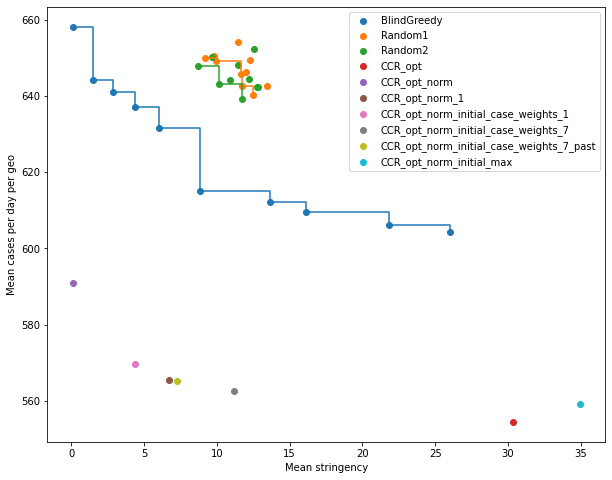

In [28]:
# Plot overall stringency and cases of each prescription
plt.figure(figsize=(10,8))
for prescriptor_name in prescriptor_names:
    pdf = final_results[final_results['PrescriptorName'] == prescriptor_name]
    overall_pdf = pdf.groupby('PrescriptionIndex').mean().reset_index()
    plt.scatter(overall_pdf['Stringency'],
                overall_pdf['PredictedDailyNewCases'], 
                label=prescriptor_name)
    plot_pareto_curve(list(overall_pdf['Stringency']),
                      list(overall_pdf['PredictedDailyNewCases']))
plt.xlabel('Mean stringency')
plt.ylabel('Mean cases per day per geo')
plt.legend()
plt.show()

In [29]:
ddf = compute_domination_df(final_results)
# Get number of dominated prescriptions for each submission. This is the "Domination Count"
ddf.groupby('DominatingName').count().sort_values('DominatedIndex', ascending=False)['DominatedIndex']

Computing domination for Canada nan


DominatingName
CCR_opt_norm                                29
CCR_opt_norm_initial_case_weights_1         26
CCR_opt_norm_1                              25
CCR_opt_norm_initial_case_weights_7_past    25
BlindGreedy                                 20
CCR_opt_norm_initial_case_weights_7         17
Random2                                      9
Random1                                      5
CCR_opt                                      1
Name: DominatedIndex, dtype: int64